Here we train the convolutional neural network:
We require the following folders:
- DataFiltered: contains the filtered data by class and tranformed
- labels.csv: contains the labels of the data

What we first do is filter the data into training, test and validation sets. 

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

We filter the data into train/val/test in ratio 80|10|10.

In [27]:
labeling = pd.read_csv('labels.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
5959,994_i180.png,994,"wood,paper"
5960,994_i190.png,994,"wood,paper"
5961,994_i210.png,994,"wood,paper"
5962,994_i230.png,994,"wood,paper"


In [28]:
unique_item_type = labeling['item_type'].unique()

In [29]:
item_shuffle = np.random.permutation(unique_item_type)
train_item_type = item_shuffle[:int(len(item_shuffle)*0.8)]
test_item_type = item_shuffle[int(len(item_shuffle)*0.8):int(len(item_shuffle)*0.9)]
val_item_type = item_shuffle[int(len(item_shuffle)*0.9):]

In [30]:
source_dir = './DataFiltered/'
target_dir = './trainvaltest/'

In [31]:
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

In [32]:
#copy files into train/val/test based on split
if (not os.path.exists(target_dir + "train") and not os.path.exists(target_dir + "val") and not os.path.exists(target_dir + "test")):
    os.mkdir(target_dir + "train")
    os.mkdir(target_dir + "val")
    os.mkdir(target_dir + "test")

for item in train_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "train/" + row['filename'])

for item in val_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "val/" + row['filename'])

for item in test_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "test/" + row['filename'])

        

./DataFiltered/547_i110.png
./DataFiltered/547_i120.png
./DataFiltered/547_i130.png
./DataFiltered/547_i140.png
./DataFiltered/547_i150.png
./DataFiltered/547_i160.png
./DataFiltered/547_i170.png
./DataFiltered/547_i180.png
./DataFiltered/547_i190.png
./DataFiltered/547_i210.png
./DataFiltered/547_i230.png
./DataFiltered/547_i250.png
./DataFiltered/686_i110.png
./DataFiltered/686_i120.png
./DataFiltered/686_i130.png
./DataFiltered/686_i140.png
./DataFiltered/686_i150.png
./DataFiltered/686_i160.png
./DataFiltered/686_i170.png
./DataFiltered/686_i180.png
./DataFiltered/686_i190.png
./DataFiltered/686_i210.png
./DataFiltered/686_i230.png
./DataFiltered/686_i250.png
./DataFiltered/242_i110.png
./DataFiltered/242_i120.png
./DataFiltered/242_i130.png
./DataFiltered/242_i140.png
./DataFiltered/242_i150.png
./DataFiltered/242_i160.png
./DataFiltered/242_i170.png
./DataFiltered/242_i180.png
./DataFiltered/242_i190.png
./DataFiltered/242_i210.png
./DataFiltered/242_i230.png
./DataFiltered/242_i

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [33]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


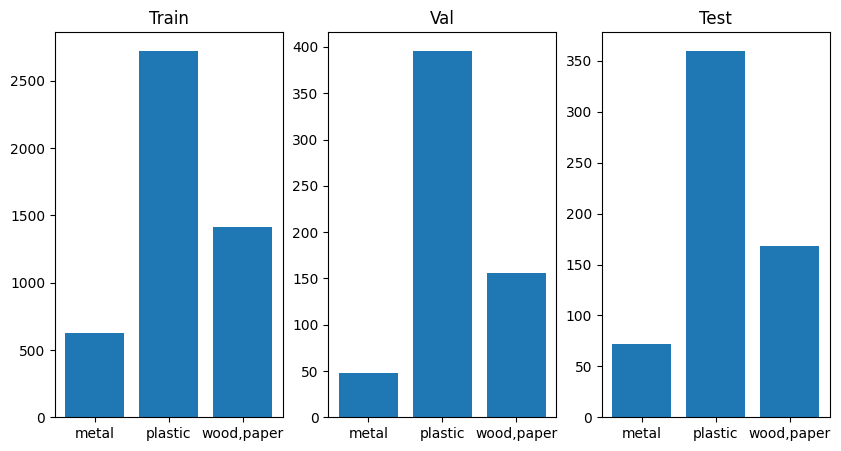

In [34]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [35]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [36]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [37]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [38]:
Top4Dataset_train = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 4764
length of val dataset: 600
length of test dataset: 600


In [39]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=8, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=8, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=8, shuffle=True)

In [40]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

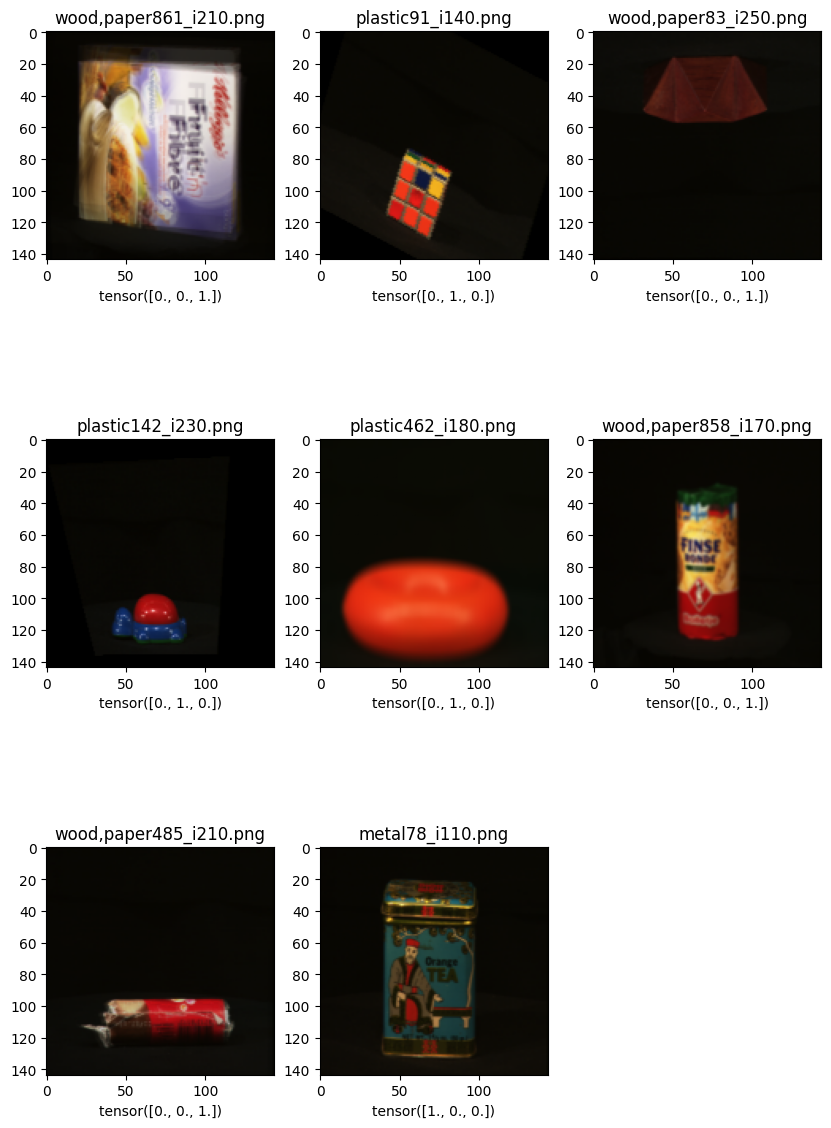

In [41]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1,2,0))
    true_label = label_list[labels[i].argmax()]
    plt.title(true_label + path[i])
    plt.xlabel(labels[i])

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13824, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 3),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13824, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
)


In [43]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y, path) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [44]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.losshistory = []
        self.trainlosshistory = []

    def early_stop(self, validation_loss, train_loss, nnmodel):
        self.losshistory.append(validation_loss)
        self.trainlosshistory.append(train_loss)
        if validation_loss < self.min_validation_loss:
            torch.save(model.state_dict(), "model.pt")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [45]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [46]:
weight = [3.0, 1, 2.0]
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [47]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight).to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [48]:
#train model
early_stopping = EarlyStopper( patience=2, min_delta=0.0001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_test, model, loss_fn)
    early_stopping.early_stop(test_loss, train_loss, model)
    #if early_stopping.early_stop(test_loss, train_loss, model):
        #print("Early stopping")
        #break
print("Done!")

Epoch 1
-------------------------------
loss: 1.531795  [    0/ 4764]
loss: 1.446961  [  800/ 4764]
loss: 1.248920  [ 1600/ 4764]
loss: 1.787070  [ 2400/ 4764]
loss: 1.667130  [ 3200/ 4764]
loss: 1.842586  [ 4000/ 4764]
Test Error: 
 Accuracy: 30.2%, Avg loss: 1.619397 

Epoch 2
-------------------------------
loss: 1.606597  [    0/ 4764]
loss: 1.345402  [  800/ 4764]
loss: 1.385931  [ 1600/ 4764]
loss: 1.179465  [ 2400/ 4764]
loss: 2.388561  [ 3200/ 4764]
loss: 1.304815  [ 4000/ 4764]
Test Error: 
 Accuracy: 34.2%, Avg loss: 1.590657 

Epoch 3
-------------------------------
loss: 1.643535  [    0/ 4764]
loss: 1.811732  [  800/ 4764]
loss: 1.454294  [ 1600/ 4764]
loss: 1.543957  [ 2400/ 4764]
loss: 1.696266  [ 3200/ 4764]
loss: 1.171307  [ 4000/ 4764]
Test Error: 
 Accuracy: 38.0%, Avg loss: 1.570189 

Epoch 4
-------------------------------
loss: 1.889417  [    0/ 4764]
loss: 1.903918  [  800/ 4764]
loss: 1.414562  [ 1600/ 4764]
loss: 1.828563  [ 2400/ 4764]
loss: 1.997733  [ 3200/ 

KeyboardInterrupt: 

In [ ]:
plt.plot(early_stopping.losshistory, label='validation loss')
plt.plot(early_stopping.trainlosshistory, label='train loss')
plt.legend()